In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    BodyIndex,
    Integrator,
    TrajectorySource,
    LeafSystem,
    Context,
    JacobianWrtVariable
)
from pydrake.trajectories import PiecewisePose
from manipulation.utils import RenderDiagram
from pydrake.math import RigidTransform
from manipulation.station import LoadScenario, MakeHardwareStation
import os
import matplotlib.pyplot as plt

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


In [4]:
bin_path = os.path.abspath("./urdfs/bin.urdf")
basket_path = os.path.abspath("./models/basket.sdf")

In [5]:
def create_simple_trajectory(XG: RigidTransform, XE: RigidTransform, duration: int = 5.0):
    return PiecewisePose.MakeLinear([0, duration], [XG, XE])

In [6]:
class IIWAPseudoInverseController(LeafSystem):
    """Spatial Velocity -> Joint Velocity"""
    def __init__(self, plant: MultibodyPlant):
        super().__init__()
        self.plant = plant
        self.plant_context = plant.CreateDefaultContext()
        self.iiwa = plant.GetModelInstanceByName("iiwa")

        # spatial veclocity input
        self.V = self.DeclareVectorInputPort("V", 6)
        self.iiwa_position = self.DeclareVectorInputPort("iiwa.position", 7)

        # output: joint velocity
        self.q = self.DeclareVectorOutputPort("q", 7, self.CalcJointVelocity)

        print("Pseudo inverse controller")

        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcJointVelocity(self, context: Context, output):
        V_G = self.V.Eval(context)
        q = self.iiwa_position.Eval(context)
        self.plant.SetPositions(self.plant_context, self.iiwa, q)
        J_G = self.plant.CalcJacobianSpatialVelocity(
            self.plant_context,
            JacobianWrtVariable.kV,
            self.plant.GetBodyByName("body").body_frame(),
            [0, 0, 0],
            self.plant.world_frame(),
            self.plant.world_frame(),
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]  # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        print(v)
        output.SetFromVector(v)

In [7]:
class DummySystem(LeafSystem):
    def __init__(self):
        super().__init__()
        self.q = self.DeclareVectorOutputPort("q", 1, self.CalcOutput)

    def CalcOutput(self, context, output):
        output.SetFromVector(np.ones(1))

In [8]:
meshcat.Delete()

scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: bin1
    # file: file:///Users/ericchen/Eric/BallPitNDF/urdfs/bin.urdf
    file: file:///Users/ericchen/Eric/BallPitNDF/models/basket.sdf
    # default_free_body_pose:
    #     bin_body:
    #         translation: [0.5, 0.5, 0.085]
- add_weld:
    parent: world
    child: bin1::basket
    # child: bin1::bin_body
    X_PC:
        translation: [0.5, 0.5, 0.0]
- add_model:
    name: ball1
    file: file:///Users/ericchen/Eric/BallPitNDF/models/ball.sdf
    default_free_body_pose:
        link:
            translation: [0.5, 0.5, 0.1]
- add_model:
    name: ball2
    file: file:///Users/ericchen/Eric/BallPitNDF/models/sphere.sdf
    default_free_body_pose:
        sphere:
            translation: [0.5, 0.5, 0.25]
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.5, 0.6, 0.1]
- add_model:
    name: foam_brick2
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.5, 0.5, 0.25]
# - add_model:
#     name: rubiks_cube
#     file: package://manipulation/rubiks_cube.sdf
#     default_free_body_pose:
#         box_m1_m1_m1:
#             translation: [0.5, 0.5, 0.1]
# - add_model:
#     name: floor
#     file: package://manipulation/floor.sdf
#     default_free_body_pose:
#         box_m1_m1_m1:
#             translation: [0, 0, 0]
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

builder = DiagramBuilder()

# load scenerio and create a hardware station -> initializes iiwa and wsg gripper
scenario = LoadScenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat)
builder.AddSystem(station)

context = station.CreateDefaultContext()

# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
plant: MultibodyPlant = station.GetSubsystemByName("plant")

plant.set_penetration_allowance(1e-4)

# get the index of the iiwa model and bins in the plant
iiwa = plant.GetModelInstanceByName("iiwa")
# bin1 = plant.GetModelInstanceByName("bin1")
# bin2 = plant.GetModelInstanceByName("bin2")
wsg = plant.GetModelInstanceByName("wsg")
print("iiwa: ", iiwa)
# print("bin1: ", bin1)
# print("bin2: ", bin2)
print("wsg: ", wsg)

# get the model
print(plant.GetModelInstanceName(iiwa))

# get the bodies in the plant
print("Getting Bodies in Plant: ")
for i in range(plant.num_bodies()):
    body = plant.get_body(BodyIndex(i))

# get the pose of the iiwa
# bin1_body = plant.GetBodyByName("bin_body", bin1)
# bin1_body = plant.GetBodyByName("basket", bin1)
# bin1_body.SetMass(context, 10.0)
plant_context = plant.GetMyContextFromRoot(context)
# X_B1 = plant.EvalBodyPoseInWorld(plant_context, bin1_body)
X_B1 = RigidTransform(p=[0.5, 0.5, 0.085])

# X_B1 = RigidTransform(p=[0.5, 0.5, 0.085])

# print("bin1_pose: ", X_B1)

# get the pose of the gripper
gripper_body = plant.GetBodyByName("body", wsg)
X_G = plant.EvalBodyPoseInWorld(plant_context, gripper_body)
# print("gripper_pose: ", X_G)

# end position
X_B1_End = RigidTransform(p=[0, 0, 0.2])
X_End = X_B1.multiply(X_B1_End)

# print("end pose: ", X_End)

# create a simple trajectory from gripper to bin
trajectory = create_simple_trajectory(X_G, X_End, 5.0)

# calculate the derivative to get the velocity
trajectory_V = trajectory.MakeDerivative()

# set up the trajectory source
trajectory_V_system = builder.AddNamedSystem("trajectory_V", TrajectorySource(trajectory_V))
controller = builder.AddNamedSystem("iiwa_pseudo_inverse_controller", IIWAPseudoInverseController(plant))

builder.Connect(trajectory_V_system.get_output_port(), controller.GetInputPort("V"))

# connect some shits together
integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(integrator.get_output_port(), station.GetInputPort("iiwa.position"))
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

dummy = builder.AddNamedSystem("dummy", DummySystem())
builder.Connect(
    dummy.get_output_port(),
    station.GetInputPort("wsg.position"),
)

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)



# print(trajectory.end_time())
diagram.ForcedPublish(context)
meshcat.StartRecording()
simulator.AdvanceTo(trajectory.end_time())
meshcat.PublishRecording()

iiwa:  ModelInstanceIndex(2)
wsg:  ModelInstanceIndex(3)
iiwa
Getting Bodies in Plant: 
Pseudo inverse controller
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030218  0.10018988 -0.59720301 -0.06882033  0.15557694
  0.23596478]
[ 0.14771886 -0.39030216  0.10018989 -0.59720299 -0.0688203   0.15557696
  0.2359648 ]
[ 0.14771886 -0.39030216  0.10018989 -0.59720299 -0.0688203   0.15557696
  0.2359648 ]
[ 0.14771886 -0.39030216  0.10018989 -0.59720299 -0.0688203   0.15557696
  0.2359648 ]
[ 0.14771884 -0.

In [92]:
for i in range(station.num_input_ports()):
    port = station.get_input_port(i)
    print(port.get_name())

iiwa.position
wsg.position
wsg.force_limit
applied_generalized_force
applied_spatial_force


In [89]:
station.GetOutputPort("iiwa.position_measured").Eval(context)

RuntimeError: OutputPort: The Context given as an argument was not created for this OutputPort[2] (iiwa.position_measured) of System ::_::station (RobotDiagram<double>)

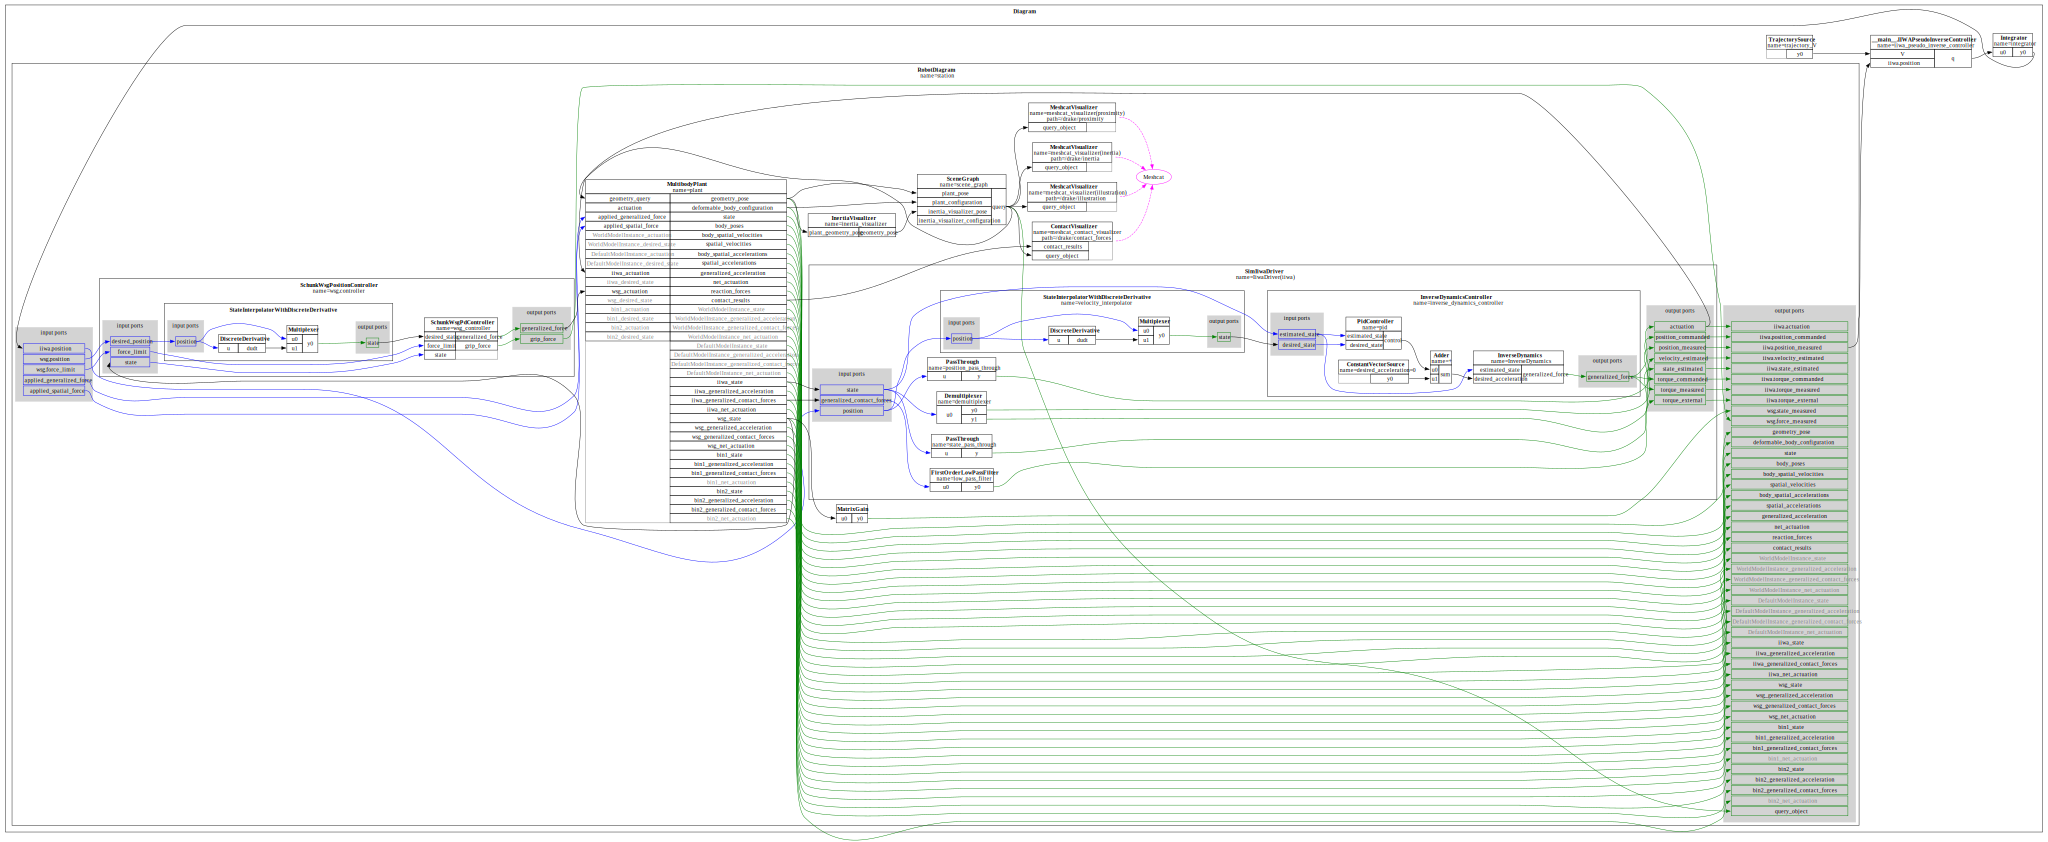

In [97]:
RenderDiagram(diagram)

In [98]:
station.GetInputPort("wsg.position").Eval(context)

RuntimeError: InputPort: The Context given as an argument was not created for this InputPort[1] (wsg.position) of System ::_::station (RobotDiagram<double>)

In [99]:
print(context)

::_ Context (of a Diagram)
---------------------------
21 total continuous states
62 total discrete states in 7 groups
1 total abstract states
438 total numeric parameters in 67 groups
17 total abstract parameters

::_::station Context (of a Diagram)
------------------------------------
14 total continuous states
62 total discrete states in 7 groups
1 total abstract states
438 total numeric parameters in 67 groups
17 total abstract parameters

::_::station::plant Context
----------------------------
Time: 0
States:
  1 discrete state groups with
     44 states
                     -1.57                 0.1                   0                   0                   0                   0                   0                   0                   0                   1                   0                   0                   0                 0.5                 0.5 0.08500000000000001                   1                   0                   0                   0                -0.5       

In [9]:
print(os.environ.get("MANIPULATION_PACKAGE_PATH"))

None
